In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import TradingGameEnv
import baseline_agents
from stable_baselines import PPO2
from stable_baselines.common.evaluation import evaluate_policy
from os import listdir
from os.path import isfile, join

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
# we need to use the same settings as the env used in training. Otherwise the agent may be confused.
NUM_PLAYERS = 2
SEQ_PER_DAY = 2
CARDS_PER_SUIT = 10
SUIT_COUNT = 1
BETTING_MARGIN = CARDS_PER_SUIT*CARDS_PER_SUIT/100
EVAL_EPISODES = int(1e3)
TRANSACTION_HISTORY_SIZE = 4

HAND_COUNT = (int) ((CARDS_PER_SUIT)/2*SUIT_COUNT/NUM_PLAYERS)

PUBLIC_CARDS_COUNT = CARDS_PER_SUIT*SUIT_COUNT - HAND_COUNT*NUM_PLAYERS

# add baseline agent
agents = []
agents.append(baseline_agents.EVAgent(agent_idx = 1, num_players = NUM_PLAYERS, betting_margin = BETTING_MARGIN, cards_per_suit = CARDS_PER_SUIT, player_hand_count = HAND_COUNT, public_cards_count = PUBLIC_CARDS_COUNT))
#agents.append(baseline_agents.EVAgent(agent_idx = 1, num_players = NUM_PLAYERS, betting_margin = BETTING_MARGIN, cards_per_suit = CARDS_PER_SUIT, player_hand_count = HAND_COUNT, public_cards_count = PUBLIC_CARDS_COUNT))

env = TradingGameEnv.TradingGameEnv(player_count = NUM_PLAYERS, other_agent_list = agents,
    seq_per_day = SEQ_PER_DAY, cards_per_suit = CARDS_PER_SUIT, player_hand_count = HAND_COUNT,
    random_seq = True, self_play = False, obs_transaction_history_size=TRANSACTION_HISTORY_SIZE, eval=True)

In [6]:
name_to_scores={}


In [28]:
time_steps = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 
              100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000]

In [5]:
# plot net arch
num_layers = [2, 3, 4]
num_neurons = [64, 128]
acts = ["Relu", "Tanh"]
for num_layer in num_layers:
    for num_neuron in num_neurons:
        for act in acts:
            POLICY_TYPE = 'MlpPolicy'+str(act)+str(num_neuron)+"_"+str(num_layer) # e.g. MlpPolicyRelu64_2
            SAVE_PATH= './model_checkpoints/plot_net_arch/' + POLICY_TYPE +'/'
                
            trained_models = [join(SAVE_PATH, "rl_model_"+ str(f) + "_steps") for f in time_steps]

            mean = []
            std = []
            
            for model_path in trained_models:
                model = PPO2.load(model_path)

                # Evaluate the agent
                mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES)
                mean.append(mean_reward)
                std.append(std_reward)
                print(model_path, " mean_reward: ", mean_reward, " std_reward: ", std_reward)
            
            
            name_to_scores[(act, num_neuron, num_layer)] = (mean, std)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





KeyboardInterrupt: 

In [11]:
with open("plot_data/name_to_scores_net_archs", 'wb') as f:
    pickle.dump(name_to_scores, f)

In [12]:
with open("plot_data/name_to_scores_net_archs", 'rb') as f:
    name_to_scores = pickle.load(f)

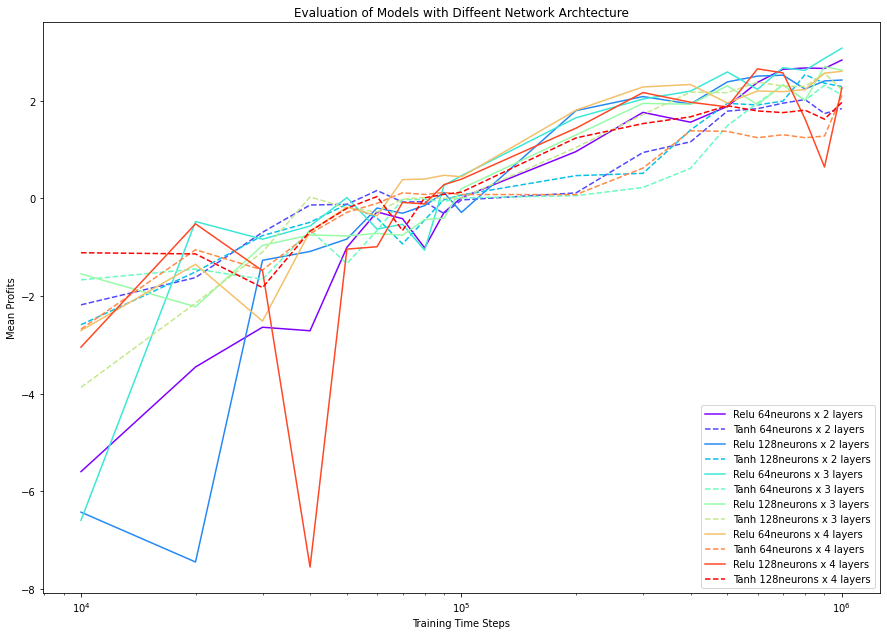

In [13]:
def plot_net_archs(xs, name_to_scores, title, std=False):
    colors = cm.rainbow(np.linspace(0, 1, len(name_to_scores.keys())))
    
    for name, c in zip(name_to_scores.keys(), colors):
        act, num_neuron, num_layer = name
        linestyle='-' if act == "Relu" else "--"
        if std:
            scores = name_to_scores[name][1]
        else:
            scores = name_to_scores[name][0]
        plt.plot(xs, scores, label=str(act)+" "+str(num_neuron)+"neurons x "+str(num_layer)+" layers",
                     linestyle=linestyle, color=c) # print mean rewards

    plt.legend(loc="lower right")
    plt.title(title)
    plt.xlabel("Training Time Steps")
    if std:
        plt.ylabel("Standard Deviation Profits")
    else:
        plt.ylabel("Mean Profits")
    plt.xscale('log')
    
    fig = plt.gcf()
    fig.set_size_inches(15, 10.5)
    # fig.savefig('test2png.png', dpi=100)

    plt.show()
    

plot_net_archs(time_steps, name_to_scores, "Evaluation of Models with Diffeent Network Archtecture", std=False)

In [ ]:
# plot % of EVAgent
percent = [0, 10, 20, 30, 40, 60, 80, 100]
for p in percent:
    EVAgent_percentage = p/100
    SAVE_PATH= './model_checkpoints/plot_EVAgent_percent/' + str(p) +'/'

    model_path = join(SAVE_PATH, "rl_model_"+ str(1000000) + "_steps")

   
    model = PPO2.load(model_path)

    # Evaluate the agent
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES)
    print(model_path, " mean_reward: ", mean_reward, " std_reward: ", std_reward)


    name_to_scores[p] = (mean_reward, std_reward)

In [ ]:
with open("plot_data/name_to_scores_EVAgent_percent", 'wb') as f:
    pickle.dump(name_to_scores, f)

In [14]:
with open("plot_data/name_to_scores_EVAgent_percent", 'rb') as f:
    name_to_scores = pickle.load(f)

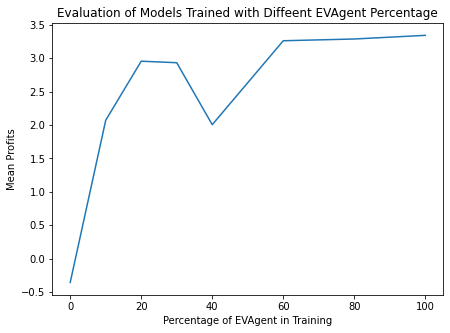

In [15]:
def plot_mean(name_to_scores, title, xlabel, plot_std=False):
    # colors = cm.rainbow(np.linspace(0, 1, len(name_to_scores.keys())))
    scores = []
    stds = []
    xs = []
    for name in name_to_scores.keys():
        score, std = name_to_scores[name]
        scores.append(score)
        stds.append(std)
        xs.append(name)
    
    plt.plot(xs, scores, linestyle="-") 
    plt.ylabel("Mean Profits")
    if plot_std:
        plt.fill_between(xs, [score + std for score, std in zip(scores, stds)], 
                         [score - std for score, std in zip(scores, stds)], facecolor='yellow', alpha=0.1)
        plt.ylabel("Mean Profits With Standard Deviation Interval")
        
    # plt.legend(loc="lower right")
    plt.title(title)
    plt.xlabel(xlabel)
    
    # plt.xscale('log')
    
    fig = plt.gcf()
    fig.set_size_inches(7, 5)
    # fig.savefig('test2png.png', dpi=100)

    plt.show()
    

plot_mean(name_to_scores, "Evaluation of Models Trained with Diffeent EVAgent Percentage", 
          "Percentage of EVAgent in Training", plot_std=False)

In [ ]:
# plot different transaction history length
length = [0, 1, 2, 4, 6, 8]
for l in length:
    TRANSACTION_HISTORY_SIZE = l
    SAVE_PATH= './model_checkpoints/plot_trans_hist_size/' + str(l) +'/'
    model_path = join(SAVE_PATH, "rl_model_"+ str(1000000) + "_steps")

   
    model = PPO2.load(model_path)

    env = TradingGameEnv.TradingGameEnv(player_count = NUM_PLAYERS, other_agent_list = agents,
            seq_per_day = SEQ_PER_DAY, cards_per_suit = CARDS_PER_SUIT, player_hand_count = HAND_COUNT,
            random_seq = True, self_play = False, obs_transaction_history_size=TRANSACTION_HISTORY_SIZE, eval=True)
    
    # Evaluate the agent
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES)
    print(model_path, " mean_reward: ", mean_reward, " std_reward: ", std_reward)


    name_to_scores[l] = (mean_reward, std_reward)

In [ ]:
with open("plot_data/name_to_scores_trans_length", 'wb') as f:
    pickle.dump(name_to_scores, f)

In [16]:
with open("plot_data/name_to_scores_trans_length", 'rb') as f:
    name_to_scores = pickle.load(f)

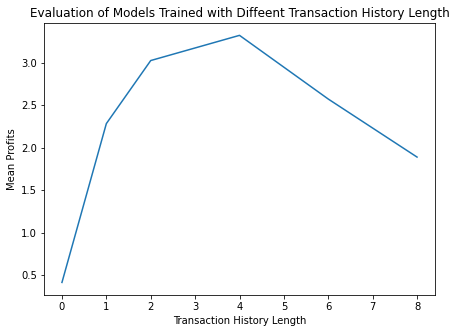

In [17]:
def plot_mean(name_to_scores, title, xlabel, plot_std=False):
    # colors = cm.rainbow(np.linspace(0, 1, len(name_to_scores.keys())))
    scores = []
    stds = []
    xs = []
    for name in name_to_scores.keys():
        score, std = name_to_scores[name]
        scores.append(score)
        stds.append(std)
        xs.append(name)
    
    plt.plot(xs, scores, linestyle="-") 
    plt.ylabel("Mean Profits")
    if plot_std == True:
        plt.fill_between(xs, [score + std for score, std in zip(scores, stds)], 
                         [score - std for score, std in zip(scores, stds)], facecolor='yellow', alpha=0.1)
        plt.ylabel("Mean Profits With Standard Deviation Interval")
        
    # plt.legend(loc="lower right")
    plt.title(title)
    plt.xlabel(xlabel)
    
    # plt.xscale('log')
    
    fig = plt.gcf()
    fig.set_size_inches(7, 5)
    # fig.savefig('test2png.png', dpi=100)

    plt.show()
    

plot_mean(name_to_scores, "Evaluation of Models Trained with Diffeent Transaction History Length", 
          "Transaction History Length", plot_std=False)

In [ ]:
# plot model bank update frequency
freq = [1, 5, 10, 100, 1000]
for f in freq:
    SELF_COPY_FREQ = f
    SAVE_PATH= './model_checkpoints/plot_model_bank_update_freq/' + str(f) +'/'
    model_path = join(SAVE_PATH, "rl_model_"+ str(1000000) + "_steps")

   
    model = PPO2.load(model_path)

    # Evaluate the agent
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES)
    print(model_path, " mean_reward: ", mean_reward, " std_reward: ", std_reward)


    name_to_scores[f] = (mean_reward, std_reward)

In [ ]:
with open("plot_data/name_to_scores_bank_freq", 'wb') as f:
    pickle.dump(name_to_scores, f)

In [18]:
with open("plot_data/name_to_scores_bank_freq", 'rb') as f:
    name_to_scores = pickle.load(f)

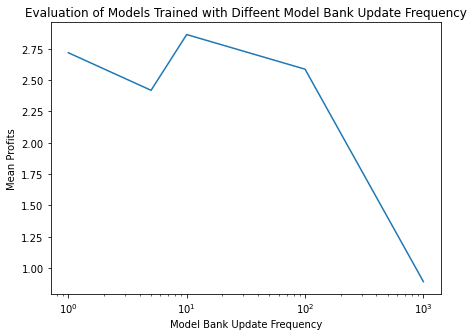

In [19]:
def plot_mean(name_to_scores, title, xlabel, plot_std=False):
    # colors = cm.rainbow(np.linspace(0, 1, len(name_to_scores.keys())))
    scores = []
    stds = []
    xs = []
    for name in name_to_scores.keys():
        score, std = name_to_scores[name]
        scores.append(score)
        stds.append(std)
        xs.append(name)
    
    plt.plot(xs, scores, linestyle="-") 
    plt.ylabel("Mean Profits")
    if plot_std == True:
        plt.fill_between(xs, [score + std for score, std in zip(scores, stds)], 
                         [score - std for score, std in zip(scores, stds)], facecolor='yellow', alpha=0.1)
        plt.ylabel("Mean Profits With Standard Deviation Interval")
        
    # plt.legend(loc="lower right")
    plt.title(title)
    plt.xlabel(xlabel)
    
    plt.xscale('log')
    
    fig = plt.gcf()
    fig.set_size_inches(7, 5)
    # fig.savefig('test2png.png', dpi=100)

    plt.show()
    

plot_mean(name_to_scores, "Evaluation of Models Trained with Diffeent Model Bank Update Frequency", 
          "Model Bank Update Frequency", plot_std=False)

In [ ]:
# plot dynamic evaluation
dynamic = [True, False]
for d in dynamic:
    DYNAMIC_EVAL = d
    SAVE_PATH= './model_checkpoints/plot_dynamic_eval/' + str(d) +'/'
        
    trained_models = [join(SAVE_PATH, "rl_model_"+ str(f) + "_steps") for f in time_steps]

    mean = []
    std = []
            
    for model_path in trained_models:
        model = PPO2.load(model_path)

        # Evaluate the agent
        mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES)
        mean.append(mean_reward)
        std.append(std_reward)
        print(model_path, " mean_reward: ", mean_reward, " std_reward: ", std_reward)
            
            
    name_to_scores[d] = (mean, std)

In [ ]:
with open("plot_data/name_to_scores_dynamic_eval", 'wb') as f:
    pickle.dump(name_to_scores, f)

In [20]:
with open("plot_data/name_to_scores_dynamic_eval", 'rb') as f:
    name_to_scores = pickle.load(f)

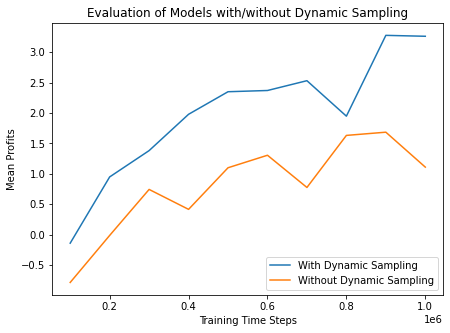

In [21]:
time_steps = [              100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000]

def plot_dynamic_eval(xs, name_to_scores, title, std=False, std_interval=False):
    colors = cm.rainbow(np.linspace(0, 1, len(name_to_scores.keys())))
    
    if std:
        plt.ylabel("Standard Deviation Profits")
    else:
        plt.ylabel("Mean Profits")
        
    for name, c in zip(name_to_scores.keys(), colors):
        if std:
            scores = name_to_scores[name][1][9:]
        else:
            scores = name_to_scores[name][0][9:]
        plt.plot(xs, scores, label="With Dynamic Sampling" if name else "Without Dynamic Sampling",
                     linestyle="-") # print mean rewards
        
        if std_interval == True:
            stds = name_to_scores[name][1][9:]
            plt.fill_between(xs, [score + std for score, std in zip(scores, stds)], 
                             [score - std for score, std in zip(scores, stds)], facecolor=c, alpha=0.1)
            plt.ylabel("Mean Profits With Standard Deviation Interval")
        
    plt.legend(loc="lower right")
    plt.title(title)
    plt.xlabel("Training Time Steps")
    # plt.xscale('log')
    
    fig = plt.gcf()
    fig.set_size_inches(7, 5)
    # fig.savefig('test2png.png', dpi=100)

    plt.show()
    

plot_dynamic_eval(time_steps, name_to_scores, "Evaluation of Models with/without Dynamic Sampling", 
                  std=False, std_interval=False)

In [ ]:
"""
# plot more cards
cards = [20, 40, 60, 80, 100]
for c in cards:
    # POLICY_TYPE = 'MlpPolicyRelu128_3'
    SAVE_PATH= './model_checkpoints/plot_cards/' + str(c) +'/'

    model_path = join(SAVE_PATH, "rl_model_"+ str(1000000) + "_steps")
   
    model = PPO2.load(model_path)
    
    CARDS_PER_SUIT = c
    BETTING_MARGIN = CARDS_PER_SUIT*CARDS_PER_SUIT/100
    HAND_COUNT = (int) ((CARDS_PER_SUIT)/2*SUIT_COUNT/NUM_PLAYERS)

    PUBLIC_CARDS_COUNT = CARDS_PER_SUIT*SUIT_COUNT - HAND_COUNT*NUM_PLAYERS


    # add 1 baseline agent
    agents = []
    agents.append(baseline_agents.EVAgent(agent_idx = 1, num_players = NUM_PLAYERS, betting_margin = BETTING_MARGIN, cards_per_suit = CARDS_PER_SUIT, player_hand_count = HAND_COUNT, public_cards_count = PUBLIC_CARDS_COUNT))


    env = TradingGameEnv.TradingGameEnv(player_count = NUM_PLAYERS, other_agent_list = agents,
            seq_per_day = SEQ_PER_DAY, cards_per_suit = CARDS_PER_SUIT, player_hand_count = HAND_COUNT,
            random_seq = True, self_play = False, obs_transaction_history_size=TRANSACTION_HISTORY_SIZE, eval=True)
    
    # Evaluate the agent
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES)
    print(model_path, " mean_reward: ", mean_reward, " std_reward: ", std_reward)


    name_to_scores[c] = (mean_reward, std_reward)
"""

In [ ]:
"""
with open("plot_data/name_to_scores_more_cards", 'wb') as f:
    pickle.dump(name_to_scores, f)
"""

In [22]:
"""
with open("plot_data/name_to_scores_more_cards", 'rb') as f:
    name_to_scores = pickle.load(f)
"""

In [24]:
"""
def plot_mean(name_to_scores, title, xlabel, plot_std=False):
    # colors = cm.rainbow(np.linspace(0, 1, len(name_to_scores.keys())))
    scores = []
    stds = []
    xs = []
    for name in name_to_scores.keys():
        score, std = name_to_scores[name]
        scores.append(score)
        stds.append(std)
        xs.append(name)
    
    plt.plot(xs, scores, linestyle="-") 
    plt.ylabel("Mean Profits")
    if plot_std == True:
        plt.fill_between(xs, [score + std for score, std in zip(scores, stds)], 
                         [score - std for score, std in zip(scores, stds)], facecolor='yellow', alpha=0.1)
        plt.ylabel("Mean Profits With Standard Deviation Interval")
        
    # plt.legend(loc="lower right")
    plt.title(title)
    plt.xlabel(xlabel)
    
    # plt.xscale('log')
    
    fig = plt.gcf()
    fig.set_size_inches(7, 5)
    # fig.savefig('test2png.png', dpi=100)

    plt.show()
    

plot_mean(name_to_scores, "Evaluation of Models Trained with Diffeent Number of Cards", 
          "Number of Cards", plot_std=False)
"""

'\ndef plot_mean(name_to_scores, title, xlabel, plot_std=False):\n    # colors = cm.rainbow(np.linspace(0, 1, len(name_to_scores.keys())))\n    scores = []\n    stds = []\n    xs = []\n    for name in name_to_scores.keys():\n        score, std = name_to_scores[name]\n        scores.append(score)\n        stds.append(std)\n        xs.append(name)\n    \n    plt.plot(xs, scores, linestyle="-") \n    plt.ylabel("Mean Profits")\n    if plot_std == True:\n        plt.fill_between(xs, [score + std for score, std in zip(scores, stds)], \n                         [score - std for score, std in zip(scores, stds)], facecolor=\'yellow\', alpha=0.1)\n        plt.ylabel("Mean Profits With Standard Deviation Interval")\n        \n    # plt.legend(loc="lower right")\n    plt.title(title)\n    plt.xlabel(xlabel)\n    \n    # plt.xscale(\'log\')\n    \n    fig = plt.gcf()\n    fig.set_size_inches(7, 5)\n    # fig.savefig(\'test2png.png\', dpi=100)\n\n    plt.show()\n    \n\nplot_mean(name_to_scores, "E

In [ ]:
# plot more players
"""
players = [2, 3, 4, 5, 6, 10, 15]
for p in players:
    # POLICY_TYPE = 'MlpPolicyRelu128_3'
    SAVE_PATH= './model_checkpoints/plot_players/' + str(p) +'/'
    model_path = join(SAVE_PATH, "rl_model_"+ str(1000000) + "_steps")
    model = PPO2.load(model_path)
    
    NUM_PLAYERS = p
    CARDS_PER_SUIT = 30
    BETTING_MARGIN = CARDS_PER_SUIT*CARDS_PER_SUIT/100
    HAND_COUNT = (int) ((CARDS_PER_SUIT)/2*SUIT_COUNT/NUM_PLAYERS)

    PUBLIC_CARDS_COUNT = CARDS_PER_SUIT*SUIT_COUNT - HAND_COUNT*NUM_PLAYERS


    # add baseline agents
    agents = []
    for i in range(p-1):
        agents.append(baseline_agents.EVAgent(agent_idx = i+1, num_players = NUM_PLAYERS, betting_margin = BETTING_MARGIN, cards_per_suit = CARDS_PER_SUIT, player_hand_count = HAND_COUNT, public_cards_count = PUBLIC_CARDS_COUNT))

    
    env = TradingGameEnv.TradingGameEnv(player_count = NUM_PLAYERS, other_agent_list = agents,
            seq_per_day = SEQ_PER_DAY, cards_per_suit = CARDS_PER_SUIT, player_hand_count = HAND_COUNT,
            random_seq = True, self_play = False, obs_transaction_history_size=TRANSACTION_HISTORY_SIZE, eval=True)
    
    # Evaluate the agent
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES)
    print(model_path, " mean_reward: ", mean_reward, " std_reward: ", std_reward)


    name_to_scores[p] = (mean_reward, std_reward)
"""

In [ ]:
"""
with open("name_to_scores_more_players", 'wb') as f:
    pickle.dump(name_to_scores, f)
"""

In [ ]:
"""
with open("name_to_scores_more_players", 'rb') as f:
    name_to_scores = pickle.load(f)
"""

In [ ]:
"""
def plot_mean(name_to_scores, title, xlabel, plot_std=False):
    # colors = cm.rainbow(np.linspace(0, 1, len(name_to_scores.keys())))
    scores = []
    stds = []
    xs = []
    for name in name_to_scores.keys():
        score, std = name_to_scores[name]
        scores.append(score)
        stds.append(std)
        xs.append(name)
    
    plt.plot(xs, scores, linestyle="-") 
    plt.ylabel("Mean Profits")
    if plot_std == True:
        plt.fill_between(xs, [score + std for score, std in zip(scores, stds)], 
                         [score - std for score, std in zip(scores, stds)], facecolor='yellow', alpha=0.1)
        plt.ylabel("Mean Profits With Standard Deviation Interval")
        
    # plt.legend(loc="lower right")
    plt.title(title)
    plt.xlabel(xlabel)
    
    # plt.xscale('log')
    
    fig = plt.gcf()
    fig.set_size_inches(7, 5)
    # fig.savefig('test2png.png', dpi=100)

    plt.show()
    

plot_mean(name_to_scores, "Evaluation of Models Trained with Diffeent Number of Players", 
          "Number of Players", plot_std=False)
"""

In [ ]:
# plot hyper param tuning
tuning = [True, False]
for t in tuning:
    SAVE_PATH= './model_checkpoints/plot_tuning/' + str(t) +'/'
        
    trained_models = [join(SAVE_PATH, "rl_model_"+ str(f) + "_steps") for f in time_steps]

    mean = []
    std = []
            
    for model_path in trained_models:
        model = PPO2.load(model_path)

        # Evaluate the agent
        mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES)
        mean.append(mean_reward)
        std.append(std_reward)
        print(model_path, " mean_reward: ", mean_reward, " std_reward: ", std_reward)
            
            
    name_to_scores[t] = (mean, std)

In [ ]:
with open("name_to_scores_tuning", 'wb') as f:
    pickle.dump(name_to_scores, f)

In [25]:
with open("name_to_scores_tuning", 'rb') as f:
    name_to_scores = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'name_to_scores_tuning'

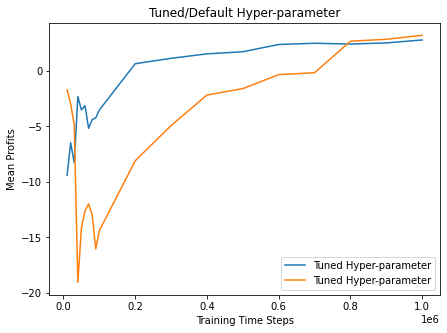

In [29]:
# time_steps = [              100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000]

def plot_tuning(xs, name_to_scores, title, std=False, std_interval=False):
    colors = cm.rainbow(np.linspace(0, 1, len(name_to_scores.keys())))
    
    if std:
        plt.ylabel("Standard Deviation Profits")
    else:
        plt.ylabel("Mean Profits")
        
    for name, c in zip(name_to_scores.keys(), colors):
        if std:
            scores = name_to_scores[name][1]
        else:
            scores = name_to_scores[name][0]
        plt.plot(xs, scores, label="Tuned Hyper-parameter" if name else "Default Hyper-parameter",
                     linestyle="-") # print mean rewards
        
        if std_interval == True:
            stds = name_to_scores[name][1]
            plt.fill_between(xs, [score + std for score, std in zip(scores, stds)], 
                             [score - std for score, std in zip(scores, stds)], facecolor=c, alpha=0.1)
            plt.ylabel("Mean Profits With Standard Deviation Interval")
        
    plt.legend(loc="lower right")
    plt.title(title)
    plt.xlabel("Training Time Steps")
    # plt.xscale('log')
    
    fig = plt.gcf()
    fig.set_size_inches(7, 5)
    # fig.savefig('test2png.png', dpi=100)

    plt.show()
    

plot_tuning(time_steps, name_to_scores, "Tuned/Default Hyper-parameter", 
                  std=False, std_interval=False)

In [ ]:
# plot more cards
cards = [10, 20]
for t in cards:
    SAVE_PATH= './model_checkpoints/plot_cards/MlpPolicyRelu64_3PenaltyTenPercent' + str(t) +'/'
        
    trained_models = [join(SAVE_PATH, "rl_model_"+ str(f) + "_steps") for f in time_steps]

    mean = []
    std = []
            
    CARDS_PER_SUIT = t
    BETTING_MARGIN = CARDS_PER_SUIT*CARDS_PER_SUIT/100
    HAND_COUNT = (int) ((CARDS_PER_SUIT)/2*SUIT_COUNT/NUM_PLAYERS)

    PUBLIC_CARDS_COUNT = CARDS_PER_SUIT*SUIT_COUNT - HAND_COUNT*NUM_PLAYERS


    # add 1 baseline agent
    agents = []
    agents.append(baseline_agents.EVAgent(agent_idx = 1, num_players = NUM_PLAYERS, betting_margin = BETTING_MARGIN, cards_per_suit = CARDS_PER_SUIT, player_hand_count = HAND_COUNT, public_cards_count = PUBLIC_CARDS_COUNT))


    env = TradingGameEnv.TradingGameEnv(player_count = NUM_PLAYERS, other_agent_list = agents,
            seq_per_day = SEQ_PER_DAY, cards_per_suit = CARDS_PER_SUIT, player_hand_count = HAND_COUNT,
            random_seq = True, self_play = False, obs_transaction_history_size=TRANSACTION_HISTORY_SIZE, eval=True)
    
    for model_path in trained_models:
        model = PPO2.load(model_path)

        # Evaluate the agent
        mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES)
        mean.append(mean_reward)
        std.append(std_reward)
        print(model_path, " mean_reward: ", mean_reward, " std_reward: ", std_reward)
            
            
    name_to_scores[t] = (mean, std)

In [ ]:
with open("name_to_scores_more_cards", 'wb') as f:
    pickle.dump(name_to_scores, f)

In [30]:
with open("name_to_scores_more_cards", 'rb') as f:
    name_to_scores = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'name_to_scores_more_cards'

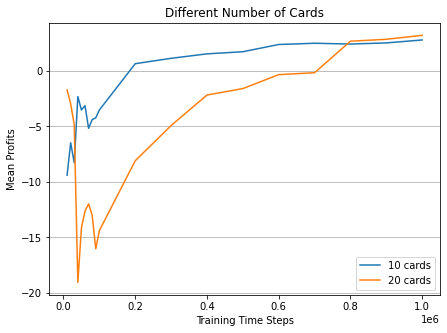

In [31]:
# time_steps = [              100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000]

def plot_cards(xs, name_to_scores, title, std=False, std_interval=False):
    colors = cm.rainbow(np.linspace(0, 1, len(name_to_scores.keys())))
    
    if std:
        plt.ylabel("Standard Deviation Profits")
    else:
        plt.ylabel("Mean Profits")
        
    for name, c in zip(name_to_scores.keys(), colors):
        if std:
            scores = name_to_scores[name][1]
        else:
            scores = name_to_scores[name][0]
        plt.plot(xs, scores, label=str(name) +" cards",
                     linestyle="-") # print mean rewards
        
        if std_interval == True:
            stds = name_to_scores[name][1]
            plt.fill_between(xs, [score + std for score, std in zip(scores, stds)], 
                             [score - std for score, std in zip(scores, stds)], facecolor=c, alpha=0.1)
            plt.ylabel("Mean Profits With Standard Deviation Interval")
        
    plt.legend(loc="lower right")
    plt.title(title)
    plt.xlabel("Training Time Steps")
    # plt.xscale('log')
    
    fig = plt.gcf()
    fig.set_size_inches(7, 5)
    # fig.savefig('test2png.png', dpi=100)
    plt.grid(axis = 'y')
    plt.show()
    

plot_cards(time_steps, name_to_scores, "Different Number of Cards", 
                  std=False, std_interval=False)

In [ ]:
# plot more players
players = [2, 3]
for t in players:
    SAVE_PATH= './model_checkpoints/plot_players/MlpPolicyRelu64_3PenaltyTenPercent' + str(t) +'/'
        
    trained_models = [join(SAVE_PATH, "rl_model_"+ str(f) + "_steps") for f in time_steps]

    mean = []
    std = []
            
    NUM_PLAYERS = t
    CARDS_PER_SUIT = int(t*2+6)
    BETTING_MARGIN = CARDS_PER_SUIT*CARDS_PER_SUIT/100
    HAND_COUNT = (int) ((CARDS_PER_SUIT)/2*SUIT_COUNT/NUM_PLAYERS)

    PUBLIC_CARDS_COUNT = CARDS_PER_SUIT*SUIT_COUNT - HAND_COUNT*NUM_PLAYERS


    # add baseline agents
    agents = []
    for i in range(t-1):
        agents.append(baseline_agents.EVAgent(agent_idx = i+1, num_players = NUM_PLAYERS, betting_margin = BETTING_MARGIN, cards_per_suit = CARDS_PER_SUIT, player_hand_count = HAND_COUNT, public_cards_count = PUBLIC_CARDS_COUNT))

    
    env = TradingGameEnv.TradingGameEnv(player_count = NUM_PLAYERS, other_agent_list = agents,
            seq_per_day = SEQ_PER_DAY, cards_per_suit = CARDS_PER_SUIT, player_hand_count = HAND_COUNT,
            random_seq = True, self_play = False, obs_transaction_history_size=TRANSACTION_HISTORY_SIZE, eval=True)
    
    for model_path in trained_models:
        model = PPO2.load(model_path)

        # Evaluate the agent
        mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES)
        mean.append(mean_reward)
        std.append(std_reward)
        print(model_path, " mean_reward: ", mean_reward, " std_reward: ", std_reward)
            
            
    name_to_scores[t] = (mean, std)

In [ ]:
with open("name_to_scores_more_players", 'wb') as f:
    pickle.dump(name_to_scores, f)

In [32]:
with open("name_to_scores_more_players", 'rb') as f:
    name_to_scores = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'name_to_scores_more_players'

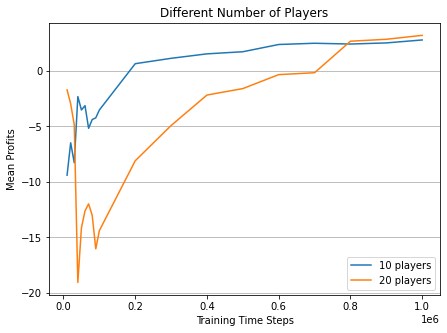

In [33]:
# time_steps = [              100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000]

def plot_cards(xs, name_to_scores, title, std=False, std_interval=False):
    colors = cm.rainbow(np.linspace(0, 1, len(name_to_scores.keys())))
    
    if std:
        plt.ylabel("Standard Deviation Profits")
    else:
        plt.ylabel("Mean Profits")
        
    for name, c in zip(name_to_scores.keys(), colors):
        if std:
            scores = name_to_scores[name][1]
        else:
            scores = name_to_scores[name][0]
        plt.plot(xs, scores, label=str(name) +" players",
                     linestyle="-") # print mean rewards
        
        if std_interval == True:
            stds = name_to_scores[name][1]
            plt.fill_between(xs, [score + std for score, std in zip(scores, stds)], 
                             [score - std for score, std in zip(scores, stds)], facecolor=c, alpha=0.1)
            plt.ylabel("Mean Profits With Standard Deviation Interval")
        
    plt.legend(loc="lower right")
    plt.title(title)
    plt.xlabel("Training Time Steps")
    # plt.xscale('log')
    
    fig = plt.gcf()
    fig.set_size_inches(7, 5)
    # fig.savefig('test2png.png', dpi=100)
    plt.grid(axis = 'y')
    plt.show()
    

plot_cards(time_steps, name_to_scores, "Different Number of Players", 
                  std=False, std_interval=False)